# Car Price Predictions

**Task:** predict the price of a used car in the test data.

**Data:** taken from 100,000 UK Used Car Data set and (probably) augmented.

**cars_train.csv** contains instances with the target variable (price) included. 

**cars_test.csv** contains instances without associated values of the target variable. 

**Quality measure:** MAPE


## Import libraries

In [1]:
!pip install sklearn_pandas
!pip install scikit-learn --upgrade
!pip install sklearn
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer

# https://dunyaoguz.github.io/my-blog/dataframemapper.html
from sklearn_pandas import DataFrameMapper

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression

## 1. Data pre-processing and analysis

In [3]:
train_data = pd.read_csv('car_train.csv', index_col='id')
train_data

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
id,,,,,,,,,,,
0,vauxhall,Astra,2017.0,Manual,19000 km,Diesel,20.0,72.4,1.6,NaN,10095
1,ford,Focus,2017.0,Manual,26973 km,Petrol,145.0,57.7,1.0,NaN,11999
2,Mercedes-Benz,A Class,2019.0,Manual,2078 km,Petrol,145.0,47.1,1.3,NaN,23299
3,toyota,Aygo,2016.0,Manual,20169 km,Petrol,0.0,69.0,1.0,NaN,6698
4,bmw,4 Series,2016.0,Manual,97706 km,Diesel,30.0,62.8,2.0,NaN,11250
...,...,...,...,...,...,...,...,...,...,...,...
98943,audi,A8,2018.0,Automatic,4284 km,Petrol,145.0,37.7,3.0,NaN,38500
98944,vauxhall,Mokka X,2019.0,Manual,9558 km,Petrol,145.0,39.2,1.4,NaN,14298
98945,vw,Passat,2016.0,Manual,51241 km,Diesel,20.0,68.9,2.0,NaN,11995


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98948 entries, 0 to 98947
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         98948 non-null  object 
 1   model         98948 non-null  object 
 2   year          98939 non-null  float64
 3   transmission  98948 non-null  object 
 4   mileage       98948 non-null  object 
 5   fuelType      98948 non-null  object 
 6   tax           85970 non-null  float64
 7   mpg           90426 non-null  float64
 8   engineSize    98948 non-null  float64
 9   tax(£)        4456 non-null   float64
 10  price         98948 non-null  int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 9.1+ MB


In [5]:
train_data.describe()

,year,tax,mpg,engineSize,tax(£),price
count,98939.000000,85970.000000,90426.000000,98948.000000,4456.000000,98948.000000
mean,2017.095331,120.248924,55.171346,1.661181,120.828097,16882.304453
std,2.138149,63.467639,16.098416,0.556509,58.352896,9744.497982
min,1970.000000,0.000000,0.300000,0.000000,0.000000,-695.000000
25%,2016.000000,125.000000,47.100000,1.200000,125.000000,10200.000000
50%,2017.000000,145.000000,54.300000,1.600000,145.000000,14691.000000
75%,2019.000000,145.000000,62.800000,2.000000,145.000000,20899.000000
max,2060.000000,580.000000,470.800000,6.600000,555.000000,159999.000000


The most obvious problems are: dataset contains gaps - NaNs, tax(£) seems as not-really-complete variable and mileage is object. Year&price have unreal values 

### Pre-processing

In [6]:
train_data['tax'] = train_data['tax'].fillna(train_data.pop('tax(£)')) ## move tax (p) to tax column
#values and all of the observations with values in tax() had nan in tax - we decided that these two columns can be united
#however nans in the resulted column are still observed - we will work with them later

In [7]:
#data without years is deleted as it is one of the most important vars & there are really few obsr-s without year 
#- we can delete them witouth any demage for data
train_data=train_data[train_data.year.isna()==False]
train_data

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
id,,,,,,,,,,
0,vauxhall,Astra,2017.0,Manual,19000 km,Diesel,20.0,72.4,1.6,10095
1,ford,Focus,2017.0,Manual,26973 km,Petrol,145.0,57.7,1.0,11999
2,Mercedes-Benz,A Class,2019.0,Manual,2078 km,Petrol,145.0,47.1,1.3,23299
3,toyota,Aygo,2016.0,Manual,20169 km,Petrol,0.0,69.0,1.0,6698
4,bmw,4 Series,2016.0,Manual,97706 km,Diesel,30.0,62.8,2.0,11250
...,...,...,...,...,...,...,...,...,...,...
98943,audi,A8,2018.0,Automatic,4284 km,Petrol,145.0,37.7,3.0,38500
98944,vauxhall,Mokka X,2019.0,Manual,9558 km,Petrol,145.0,39.2,1.4,14298
98945,vw,Passat,2016.0,Manual,51241 km,Diesel,20.0,68.9,2.0,11995


In [8]:
#If there are prices with 0, these are mistakes, obviously. Or extremly kind sellers
train_data=train_data[train_data.price>0]

In [9]:
train_data.info() #taxes, mpg, tax() - nans

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98926 entries, 0 to 98947
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         98926 non-null  object 
 1   model         98926 non-null  object 
 2   year          98926 non-null  float64
 3   transmission  98926 non-null  object 
 4   mileage       98926 non-null  object 
 5   fuelType      98926 non-null  object 
 6   tax           90406 non-null  float64
 7   mpg           90406 non-null  float64
 8   engineSize    98926 non-null  float64
 9   price         98926 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 8.3+ MB


In [10]:
#we cannot observe data from the future - it is impossible to change the year correctly in this case, better reduce such obs-ns
train_data=train_data[train_data.year<2023]

In [11]:
#correct mileage
train_data['mileage']=list(map(lambda x:int(str(x).split()[0]),train_data['mileage']))
train_data.info()                

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98925 entries, 0 to 98947
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         98925 non-null  object 
 1   model         98925 non-null  object 
 2   year          98925 non-null  float64
 3   transmission  98925 non-null  object 
 4   mileage       98925 non-null  int64  
 5   fuelType      98925 non-null  object 
 6   tax           90405 non-null  float64
 7   mpg           90405 non-null  float64
 8   engineSize    98925 non-null  float64
 9   price         98925 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 8.3+ MB


In [12]:
numeric_features = train_data.select_dtypes('number').columns.tolist()
nominal_features = train_data.select_dtypes(object).columns

### Dependencies and patterns

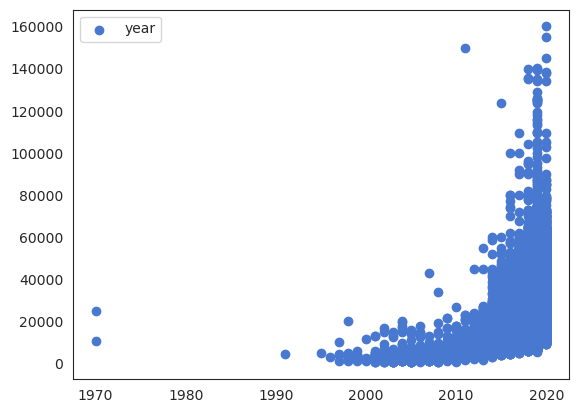

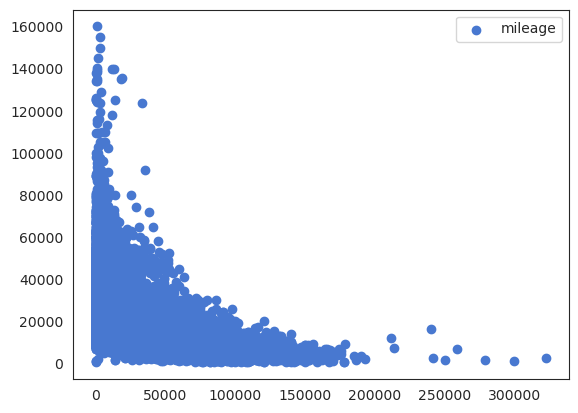

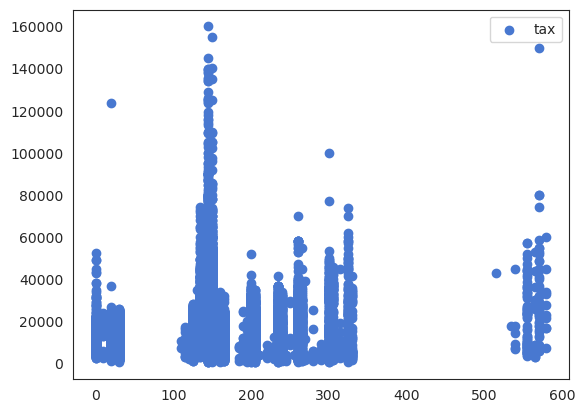

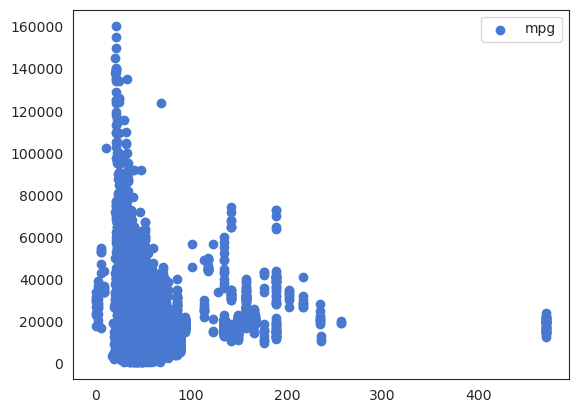

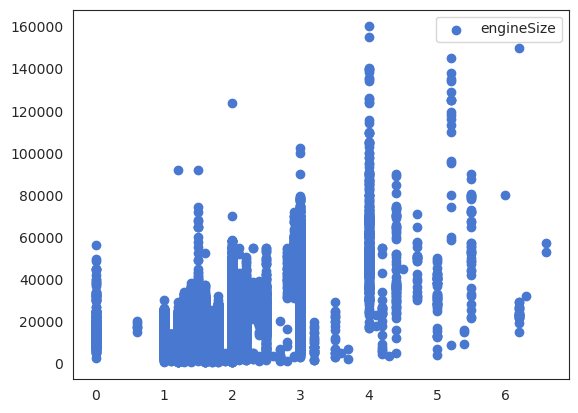

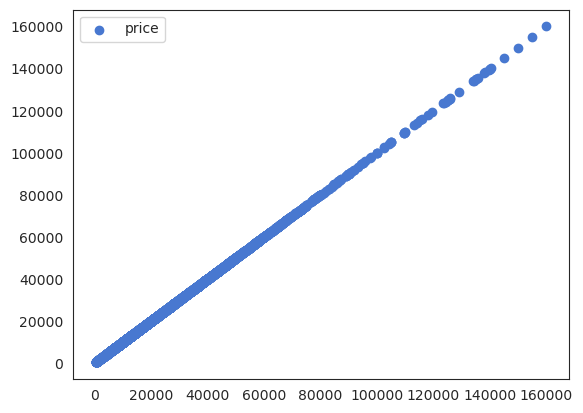

In [13]:
#we want to look at the possible shapes of the dependencies between X and Y
for column in numeric_features:
    plt.scatter(train_data[column],train_data.price,label=str(column))
    plt.legend()
    plt.show()
    

#### Some conclusions: 
It seems like year and mileage may have non-linear dependency with price. 
We will try to include non-linearity in models later.

### Correlations

In [14]:
import scipy

<Axes: >

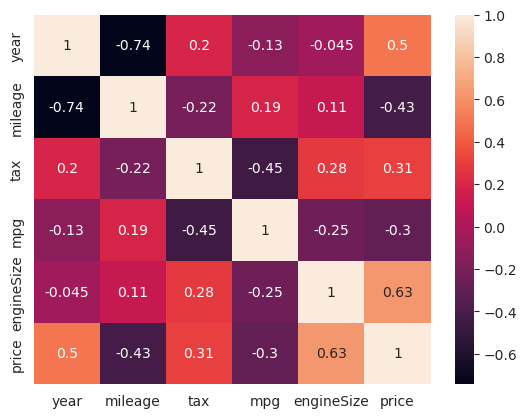

In [15]:
sns.heatmap(train_data.corr(),annot=True)


We can see really small correlation between mpg&tax and price. We will try to exlude them later.

### Outliers

As a possible way to work with outliers, we can analyze prices for each brand and try to exclude extremly expensive cars, as these prices can be both non-representative or incorrect. We thought about the idea of just cutting off, for example, 99% quantile, but in reality the boarder can be different for different brands or models and so on, so we just looked through all brands and identify some kind of threshold visually to simplify this part of work. As for the result (we did not include it in output but it is very easy to check just avoiding this part of pre-processing), we found, that Models which were trained on the data without outlayers were always a little bit more accurate (about 1% MAPE)  

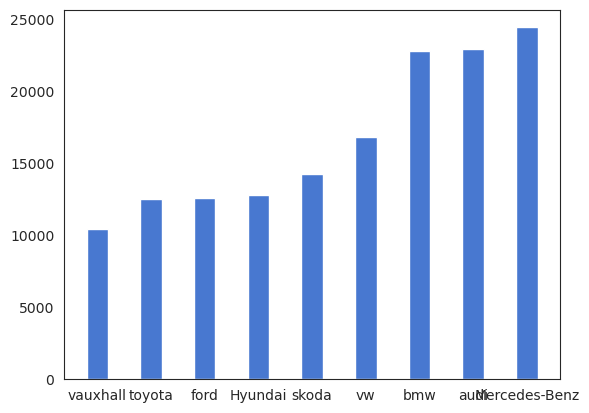

In [16]:
brands=pd.pivot_table(train_data,index='brand',values='price',aggfunc='mean').sort_values('price').reset_index()
plt.bar(brands.brand,brands.price,width=0.4)
plt.show()

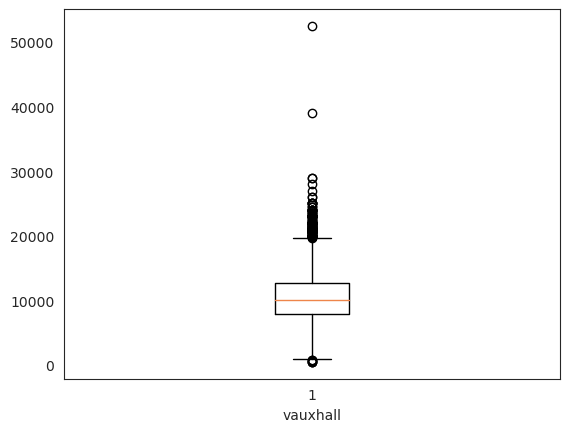

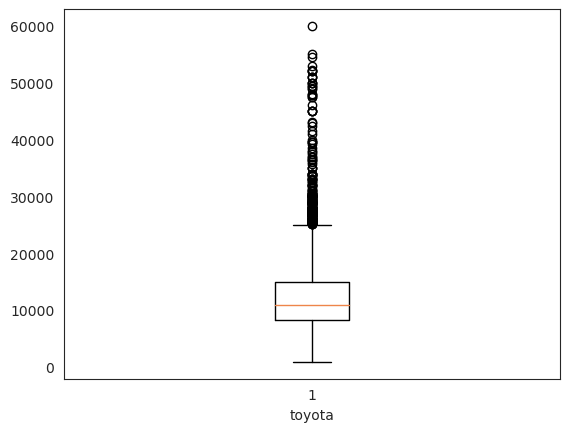

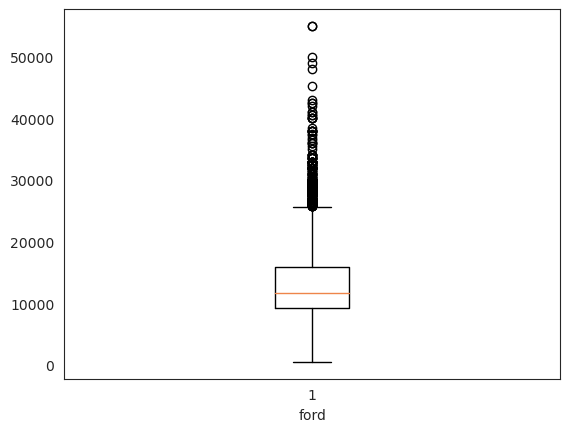

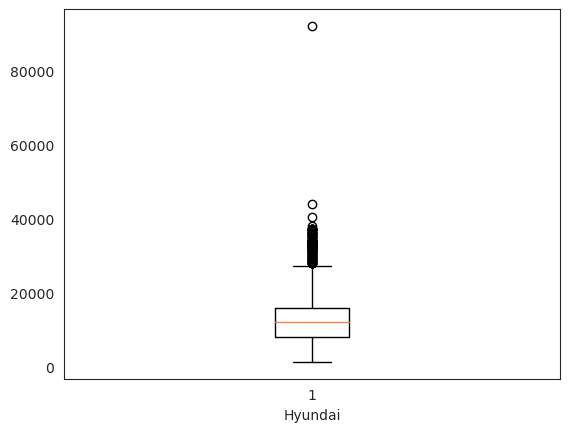

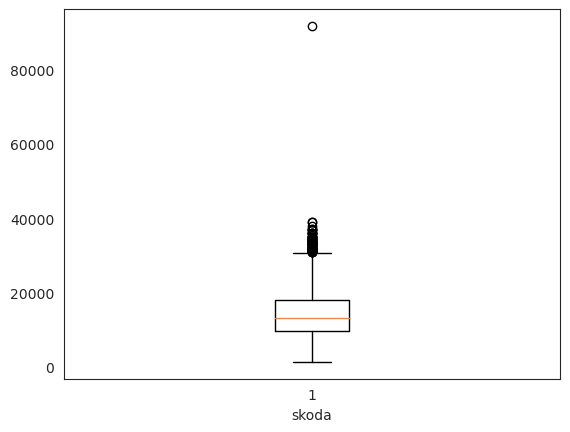

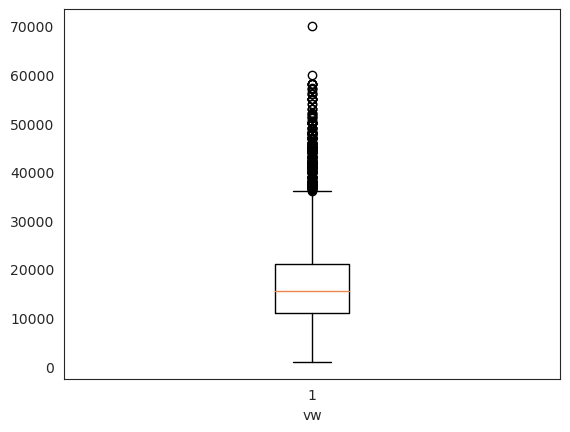

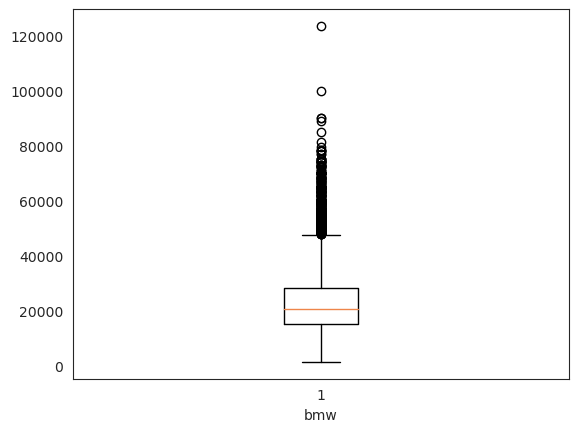

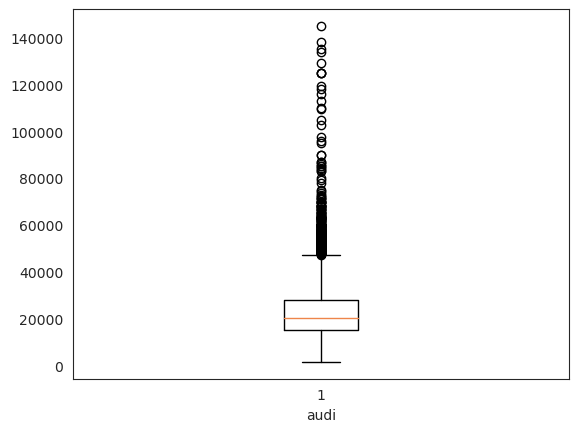

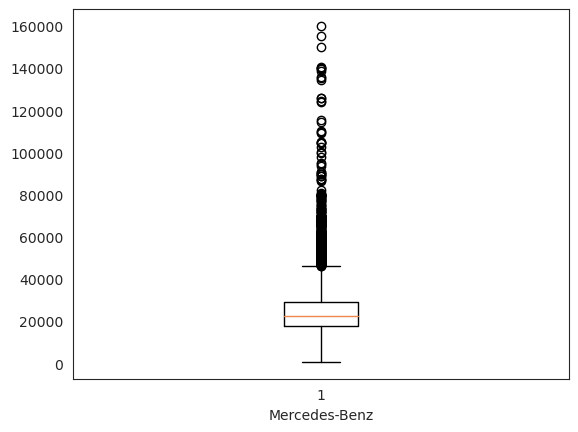

In [17]:
for brand in brands.brand:
    plt.boxplot(train_data[train_data['brand']==brand]['price'].values)
    plt.xlabel(brand)
    plt.show()

In [18]:
def rules_for_delete(brand,price):
    if ((brand=='vauxhall')&(price>30000))or((brand=='toyota')&(price>50000))or((brand=='ford')&(price>50000))or((brand=='Hyundai')&(price>40000))or((brand=='vw')&(price>60000))or((brand=='bmw')&(price>90000))or((brand=='audi')&(price>130000))or((brand=='Mercedes-Benz')&(price>130000)):
        return 1
    else:
        return 0

In [19]:
train_data['del']=list(map(rules_for_delete,train_data.brand,train_data.price))
train_data=train_data[train_data['del']==0]
del train_data['del']

### More pre-processing

Here we have created some functions to make our data preprocessing a little nicer:

In [20]:

def create_dataset(dataset,simple_imputer_condition_strategy,numeric_features):
    result=DataFrameMapper([([feature], SimpleImputer(strategy=simple_imputer_condition_strategy)) for feature in numeric_features] +\
                         [([feature], OneHotEncoder(handle_unknown = 'ignore')) for feature in nominal_features], 
                            df_out=True)
    result=result.fit_transform(dataset)

    
    return result

def standart_sc(train,test):
    result_d=StandardScaler().fit(train[numeric_features_for_prep])
    train[numeric_features_for_prep]=StandardScaler().fit_transform(train[numeric_features_for_prep])
    test[numeric_features_for_prep]=result_d.fit_transform(test[numeric_features_for_prep])
    return train, test, result_d
def inverse_st_pred(price,x_test,result_d):
    x_test_pr=x_test.copy()
    x_test_pr['price']=price
    x_test_pr[numeric_features_for_prep]=result_d.inverse_transform(x_test_pr[numeric_features_for_prep])
    return x_test_pr['price']

In [21]:
numeric_features_for_prep=['mileage', 'tax', 'mpg', 'engineSize', 'price','year']

## 2. Model training and results observation

### First actions
We tried to use simple Linear Regression but combining different specifications

$$
price_1 = brand+model+transm+fuel++milage+tax+year+mpg+engineSize
$$

$$
price_2 = brand+model+transm+fuel+milage+\frac{1}{milage}+tax+year+exp(year)+mpg+engineSize
$$

$$
price_3 = brand+model+transm+fuel+milage+(year)+engineSize
$$

$$
price_4 = brand+model+transm+fuel+milage+\frac{1}{milage}+(year)+exp(year)+engineSize
$$

$$
ln(price)_5=ln(numeric)+dummy
$$

In the very end we found that average MAPE for all of the models was 16% without significant overfitting for train set. However, approximately 200 dummies created a problem of det(X'X)=0 and the results were quite strange for several observations (a millions or even billions of pounds per car) - and mape value was extremly high. We added some kind of checking process for extreme values and it helped but the overall prediction power still remained only 16%.

We tried different ways of NANs correction and found that there was no real difference between mean, median or mode approaches, so we decided to use just median in the further models.

The same was for standartization, so we decided not to make it in the final models.

To increase prediction power, we tried to use Boost models and Decision Tree. For XGB we checked different params and decided on the following parameters to be the best for this task.

$$
price_6 = GradientBoostingRegressor(brand+model+transm+fuel++milage+tax+year+mpg+engineSize)
$$

$$
price_7 = XGBRegressor(brand+model+transm+fuel++milage+tax+year+mpg+engineSize)
$$

$$
price_8 = DecisionTreeReg(brand+model+transm+fuel++milage+tax+year+mpg+engineSize)
$$


In [22]:
columns=['specification','model','R2 test','mape test','R2 train','mape train']
result_df=pd.DataFrame(np.ones((1,len(columns))),columns=columns)
result_df
                       

,specification,model,R2 test,mape test,R2 train,mape train
0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
def result_for_df(number_of_try, name_of_the_model,result_train,result_test,y_train,y_test):
    return [number_of_try,
            name_of_the_model,
            r2_score(y_test,result_test), 
            mean_absolute_percentage_error(y_true=y_test, y_pred = result_test),
            r2_score(y_train,result_train), 
            mean_absolute_percentage_error(y_true=y_train, y_pred = result_train)]

In [24]:
dataset=create_dataset(train_data,'median',numeric_features)
need_scaler=False
for index in list(range(1,11)):
    iteration=index
    train,test=train_test_split(dataset, test_size = 0.3)
    if need_scaler==True:
        train, test, result_d=standart_sc(train,test)
    correction_sw=True
    x_train=train.drop(columns='price')
    y_train=train.price.copy()
    x_test=test.drop(columns='price')
    y_test=test.price.copy()
    if need_scaler==True:
        y_test=inverse_st_pred(y_test,x_test,result_d)

    #model_1
    lr1 = LinearRegression().fit(x_train, y_train)
    lr_pred_train=lr1.predict(x_train)
    lr_pred_test=lr1.predict(x_test)

    if need_scaler==True:
        lr_pred_test=inverse_st_pred(lr_pred_test,x_test,result_d)
        lr_pred_train=inverse_st_pred(lr_pred_tain,x_train,result_d)
        
    result_df.loc[len(result_df)]=result_for_df(index,
                                               'LinearRegression',
                                               lr_pred_train,
                                               lr_pred_test,
                                               y_train,
                                               y_test)

    #model_2

    grBR = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)
    grBR_train=grBR.predict(x_train)
    grBR_test=grBR.predict(x_test)


    if need_scaler==True:
        grBR_test=inverse_st_pred(grBR_test,x_test,result_d)
        grBR_train=inverse_st_pred(grBR_train,x_train,result_d)



    result_df.loc[len(result_df)]=result_for_df(index,
                                               'GradientBoostingRegressor',
                                               grBR_train,
                                               grBR_test,
                                               y_train,
                                               y_test)

    #model_3
    max_depth=8
    n_estimators=400
    params = {'max_depth': max_depth,
      'n_estimators': n_estimators,
      'learning_rate': 0.3,
      'gamma': 0.1,
      'reg_lambda': 1}
    model=xgb.XGBRegressor(**params).fit(x_train,y_train)
    y_pred_xgb_test=model.predict(x_test)
    y_pred_xgb_train=model.predict(x_train)

    if need_scaler==True:
        y_pred_xgb_test=inverse_st_pred(y_pred_xgb_test,x_test,result_d)
        y_pred_xgb_train=inverse_st_pred(y_pred_xgb_train,x_train,result_d)


    result_df.loc[len(result_df)]=result_for_df(index,
                                               'XGBRegressor'+'_'+str(max_depth)+'_'+str(n_estimators),
                                               y_pred_xgb_train,
                                               y_pred_xgb_test,
                                               y_train,
                                               y_test)


    # model 4
    DecisionTree = DecisionTreeRegressor(random_state=0).fit(x_train, y_train)
    dt_train=DecisionTree.predict(x_train)
    dt_test=DecisionTree.predict(x_test)


    if need_scaler==True:
        dt_test=inverse_st_pred(dt_test,x_test,result_d)
        dt_train=inverse_st_pred(dt_train,x_train,result_d)



    result_df.loc[len(result_df)]=result_for_df(index,
                                               'DecisionTreeRegressor',
                                               dt_train,
                                               dt_test,
                                               y_train,
                                               y_test)








In [25]:
result_df=result_df.iloc[1:,:]
result_df

,specification,model,R2 test,mape test,R2 train,mape train
1,1.0,LinearRegression,0.864221,0.177535,0.864019,0.177728
2,1.0,GradientBoostingRegressor,0.906155,0.136905,0.905576,0.135546
3,1.0,XGBRegressor_8_400,0.967794,0.070406,0.987725,0.048794
4,1.0,DecisionTreeRegressor,0.940805,0.088802,0.999521,0.001088
5,2.0,LinearRegression,0.862630,0.176278,0.864789,0.178401
6,2.0,GradientBoostingRegressor,0.901280,0.138037,0.903200,0.138267
7,2.0,XGBRegressor_8_400,0.966496,0.069090,0.987488,0.049336
8,2.0,DecisionTreeRegressor,0.940380,0.089206,0.999497,0.001119
9,3.0,LinearRegression,0.865196,0.181901,0.863696,0.176821
10,3.0,GradientBoostingRegressor,0.904876,0.137416,0.903750,0.137569


In [26]:
result_df.sort_values('mape test',ascending=True)

,specification,model,R2 test,mape test,R2 train,mape train
31,8.0,XGBRegressor_8_400,0.967468,0.068705,0.987925,0.049129
11,3.0,XGBRegressor_8_400,0.967407,0.068707,0.987661,0.049455
39,10.0,XGBRegressor_8_400,0.965645,0.069060,0.987657,0.049271
7,2.0,XGBRegressor_8_400,0.966496,0.069090,0.987488,0.049336
35,9.0,XGBRegressor_8_400,0.967745,0.069148,0.987598,0.049221
15,4.0,XGBRegressor_8_400,0.966714,0.069554,0.987687,0.049422
23,6.0,XGBRegressor_8_400,0.967023,0.069759,0.987223,0.049981
27,7.0,XGBRegressor_8_400,0.967309,0.070077,0.987621,0.049563
3,1.0,XGBRegressor_8_400,0.967794,0.070406,0.987725,0.048794
19,5.0,XGBRegressor_8_400,0.966638,0.070433,0.987728,0.049463


## 3. Submission output

In [27]:
train_data = pd.read_csv('car_train.csv', index_col='id')
test_data = pd.read_csv('car_test.csv', index_col='id')
train_data['tax'] = train_data['tax'].fillna(train_data.pop('tax(£)'))
test_data['tax'] = test_data['tax'].fillna(test_data.pop('tax(£)'))
train_data=train_data[train_data.year.isna()==False]
test_data=test_data[test_data.year.isna()==False]
train_data=train_data[train_data.price>0]
train_data=train_data[train_data.year<2023]
train_data['mileage']=list(map(lambda x:int(str(x).split()[0]),train_data['mileage']))
test_data['mileage']=list(map(lambda x:int(str(x).split()[0]),test_data['mileage']))
numeric_features = train_data.select_dtypes('number').columns.tolist()
nominal_features = train_data.select_dtypes(object).columns
def create_dataset(dataset,simple_imputer_condition_strategy,numeric_features):
    result=DataFrameMapper([([feature], SimpleImputer(strategy=simple_imputer_condition_strategy)) for feature in numeric_features] +\
                         [([feature], OneHotEncoder(handle_unknown = 'ignore')) for feature in nominal_features], 
                            df_out=True)
    result=result.fit_transform(dataset)

    
    return result

def rules_for_delete(brand,price):
    if ((brand=='vauxhall')&(price>30000))or((brand=='toyota')&(price>50000))or((brand=='ford')&(price>50000))or((brand=='Hyundai')&(price>40000))or((brand=='vw')&(price>60000))or((brand=='bmw')&(price>90000))or((brand=='audi')&(price>130000))or((brand=='Mercedes-Benz')&(price>130000)):
        return 1
    else:
        return 0
    
    
numeric_features_for_prep=['mileage', 'tax', 'mpg', 'engineSize', 'price','year']
train_data['del']=list(map(rules_for_delete,train_data.brand,train_data.price))
train_data=train_data[train_data['del']==0]
del train_data['del']


train_data['df']='train'
test_data['df']='test'
test_data['price']=0
full_dataset=pd.concat([train_data,test_data], ignore_index=True, sort=False)
full_dataset_c=create_dataset(full_dataset,'median',numeric_features)
full_dataset_c['df']=full_dataset['df']
x_train=full_dataset_c[full_dataset_c['df']=='train'].drop(columns=['price','df'])
y_train=full_dataset_c[full_dataset_c['df']=='train'].price
x_test=full_dataset_c[full_dataset_c['df']=='test'].drop(columns=['price','df'])


params = {'max_depth': 6,
          'n_estimators': 400,
          'learning_rate': 0.3,
          'gamma': 0.1,
          'reg_lambda': 1}
model=xgb.XGBRegressor(**params).fit(x_train,y_train)
y_pred_xgb_6_400=model.predict(x_test)

params = {'max_depth': 8,
          'n_estimators': 400,
          'learning_rate': 0.3,
          'gamma': 0.1,
          'reg_lambda': 1}
model=xgb.XGBRegressor(**params).fit(x_train,y_train)
y_pred_xgb_8_400=model.predict(x_test)

def save_csv(prediction,name):
    pd.DataFrame(prediction,columns=['price']).to_csv(name+'.csv',sep=',')


save_csv(y_pred_xgb_6_400,'y_pred_xgb_6_400')
save_csv(y_pred_xgb_8_400,'y_pred_xgb_8_400')